## Import required libaries

In [1]:
pip install camel_tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 34.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.5 MB/s eta 0:00:00
  Created wheel for camel-kenlm: filename=camel_kenlm-2023.3.17.2-cp310-cp310-linux_x86_64.whl size=3536833 sha256=f19b92

In [2]:
pip install pyarabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 4.2 MB/s eta 0:00:00


In [37]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

import scipy.sparse
import re
import string
import pyarabic.araby as araby
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import Word
from sklearn import preprocessing

from wordcloud import WordCloud
import camel_tools
import warnings
from camel_tools.utils.dediac import dediac_safebw
from camel_tools.utils.charmap import CharMapper
from camel_tools.utils.transliterate import Transliterator
from sklearn.feature_extraction.text import TfidfVectorizer

## Define Functions for Pre-processing

In [4]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [5]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

In [6]:
def has_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    stripped_text = araby.strip_diacritics(text)
    stripped_text = araby.strip_shadda(stripped_text)
    stripped_text = araby.strip_tashkeel(stripped_text)
    if stripped_text != text:
      return 1
    else :
      return 0

In [7]:
def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', text)
    text = araby.strip_diacritics(text)
    text = araby.strip_shadda(text)
    text = araby.strip_tashkeel(text)
    return text

The presence of Latin characters will mess with transliteration later on.

so, we should remove them.
also, remove linsk (https), Hashtages and digits.

In [8]:
def remove_non_arabic(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = re.sub('([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    return text

In [9]:
def remove_repeating_characters(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    #text = re.sub(r'(.)\1+', r'\1', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text

## Read Data

In [10]:
data = pd.read_csv('/content/drive/MyDrive/Data.csv', encoding='utf-8',lineterminator='\n')

In [11]:
data['text'] = data['text'].astype(str)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147725 entries, 0 to 147724
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     147725 non-null  object
 1   dialect  147725 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [13]:
data.shape

(147725, 2)

In [14]:
data.head(20)

,text,dialect
0,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY
1,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY
2,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY
3,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY
4,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY
5,@alibobkr63 او حتى من اي دين او طائفة. اسف ممك...,LY
6,@muhamed01111 باهي نستنوه. بلكي مشغول ولا حاجة,LY
7,@muhamed01111 مهما اختلفنا راه نحنا خوت. والله...,LY
8,@muhamed01111 بالنسبة ليا انا والله شبعت هم ون...,LY
9,@Ajo32asLibya @Jed_ly مو نحنا الحياة عندنا مية...,LY


In [15]:
pd.set_option('display.max_colwidth', None)
data.sample(50)

,text,dialect
121584,@mabineder @RheaK12 كلنا منحكي نفس الكلام 🤣🤣,LB
70884,في ناس متضايقة ان في ناس كتيرة ملهمش في الكورة ومع كده راحوا الاستاد النهارده يشجعوا منتخب #مصر\nيا ابني ما أغلب لعيبة المنتخب ملهمش برضه في الكورة ومع كده رايحين النهارده الاستاد يلعبوا باسم مصر\n\nلا لخلط الكورة بالمنتخب,EG
14370,كان عندنا راه جاه السكر من الفجعة 😣😣 https://t.co/ex8rTnkHmv,LY
1829,"@fafy308 ماعاش يقدر يبعثلك شي ماتمشيش الرسائل متاع ,يعني كف ع وجهه ههههههه",LY
63477,@alexandriamoham @arabqoute وكمان \nاخو النكد والقرف والوجع والزهق والأرق والزعل وابن عم الاكتئاب \nكلهم مذكر \nسبحااااان الله\n😝😝,EG
144451,موسم هجرة الحبش لبلادهم https://t.co/cGC6l6MqYY,SD
135983,@SalMukhDirar لو مشيتي المطار ح تلقى إن شاء الله,SD
43475,#ذكريات_خضراويه\nاستنى اطلالتها في كل برايم لانه اكون متاكدة انها غتكون من احلى الطلات واحلى من الكل\n#HananeElkhader,MA
25281,@tiiiimoo ينعاد علينا و عليك يا رب,LY
130234,@mounirhafi @yasalebanon @tmclebanon هي القضيه اصعب من هيك بكتير انو جماعة الموتويات بيزتو حالن على السيارات من قدام ومن ورا ومن الجناب. إذا هني بينضبطو وبيمشو بس على خط اليمين بكون أمان الهن وإلنا ولازم الدوله تلزم هيدا المسار وكل موتو بيمشي بين السيارات ينسحب منو مباشرة.\n رحم الله عمر الداعوق,LB


In [16]:
data['dialect'].value_counts()

EG    57636
LY    36499
LB    27617
SD    14434
MA    11539
Name: dialect, dtype: int64

## Text Pre-processing

- **Removing Punctuations and Symbols**

In [17]:
english_punctuations = string.punctuation
english_punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
punctuations_list = arabic_punctuations + english_punctuations
punctuations_list

'`÷×؛<>_()*&^%][ـ،/:"؟.,\'{}~¦+|!”…“–ـ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
data['text'] = data['text'].apply(remove_punctuations)

- **Remove Emojis**

In [20]:
data['text'] = data['text'].apply(remove_emoji)

- **Stop Words Elimination**

In [21]:
nltk.download('stopwords')
stop=stopwords.words('arabic')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
stop

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [23]:
#data['text'] = data['text'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))

- **Remove Diacritics**

In [24]:
data['has_diacritics'] = data['text'].apply(has_diacritics)

In [25]:
data.groupby('dialect')['has_diacritics'].value_counts()

dialect  has_diacritics
EG       0                 54687
         1                  2949
LB       0                 24743
         1                  2874
LY       0                 35247
         1                  1252
MA       0                 11452
         1                    87
SD       0                 13854
         1                   580
Name: has_diacritics, dtype: int64

In [26]:
data['text'] = data['text'].apply(remove_diacritics)

- **Remove Non-Arabic Characters**

In [27]:
data['text'] = data['text'].apply(remove_non_arabic)

- **Remove Repeated Characters**

In [28]:
data['text'] = data['text'].apply(remove_repeating_characters)

- **Lemmatisation**

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [30]:
data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

- **Encoding the Target Classes**

In [31]:
data.dialect.unique()

array(['LY', 'MA', 'EG', 'LB', 'SD'], dtype=object)

In [32]:
# Create a dictionary to map the labels to their encoded values
label_map = {'EG': 0, 'LY': 2, 'LB': 1, 'SD': 4, 'MA': 3}

# Create a new column with the encoded labels
data['dialect']=data['dialect'].map(label_map)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147725 entries, 0 to 147724
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            147725 non-null  object
 1   dialect         147725 non-null  int64 
 2   has_diacritics  147725 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [34]:
data['dialect'].value_counts()

0    57636
2    36499
1    27617
4    14434
3    11539
Name: dialect, dtype: int64

In [35]:
data.dropna()

,text,dialect,has_diacritics
0,قليلين ادب ومنافقين لو اختهم او قريبتهم تتعاكس تقولي عليهم من نشاط حقوق المراه من رده فعلهم,2,0
1,الليبيين متقلبين بس بالنسبه ليا انا ميليشياوي زمان وتوه,2,0
2,كل تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ انها غير كل البنات وبيحس كانه يعرفها من زمان بعدين يتزوج وحده منهن وممكن اثنين ولاثلاثه وتنقلب الرومانسيه لعياط وشياط وتهزيب ذي اند,2,0
3,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل يخاف منهم علشان يكون محترم هو انسان قليل الادب اصلا ثانيا شن ذنب يلي معندهش اب ولا ام ولا خوت ولا خوات يعني اليتيمه متستحقش تتزوج وثالثا ليش البنت هي بس لازم ادير الف حساب للراجل هي متستحقش يندارلها الف حساب ولا هي عبده,2,1
4,شكلك متعقده علشان الراجل لي تحبيه ازوج بنت يتيمه ولا بنت معندهش خوت هدي اعصابك وفكينا من التخلف امتاعك,2,0
...,...,...,...
147720,الناس دي بتنفخ في قربه مقدوده بالدارجي كده البلد دي لو ما الكيزان ديل راحو مافي حياه شريفه في البلد دي لان سبب الفساد والمصاءب الموجوده التطلعلسودانافضل,4,0
147721,انت عايش وين بره السودان ولا شنو ماشايف البحصل دا,4,0
147722,مااحرم نفسي ميسي حريف ولعاب برضو مدريدي وافتخر,4,0
147723,ياخي ديل ماخلو للشيطان وابليس شي لكن يروحو وين من ربنا ونحن وراك وراك ياكوز ياعفن الايام معدوده خلاص تعرفعليالكيزان,4,0


## Saving pre-processed data

In [47]:
data = data.sample(frac=1)

In [48]:
data.to_csv('/content/drive/MyDrive/preprocessed_data2.csv')

In [49]:
data_cleaned = pd.read_csv('/content/drive/MyDrive/preprocessed_data2.csv', lineterminator='\n')

In [50]:
pd.set_option('display.max_colwidth', None)
data_cleaned.sample(50)


,Unnamed: 0,text,dialect,has_diacritics
115132,44394,سمحولي اخر حاجه بغيت نقولها هه عدد ليكات علي صوره بالابيض والاسود اكثر من عدد مشاهدات برومو عالمي تنويه اتحطو فنفس وقت,3,0
71423,21956,علي روحنا يهدي الله من طلق,2,0
126705,93090,شخصيه في الساعه تقصد ولازم تستعجب وكمان تنبهر,0,0
23979,16310,ناعلي منك يا حبها,2,0
146285,145770,روقي المنقه ماكل مان مادسيس,4,0
106696,11081,تمشي اتدور ع من تكسد بعيد ولا نضام مخدرات التهزيب لازم تاكل شويه كل يوم نمادج يخلوك تجري وتعيطي,2,0
117197,127179,في ظلم كبير ما حدا منكم مظلوم كلكن حراميه,1,0
134820,133938,ق ق ج سودانيه لو استمريت علي هذا البرود ان شاء الله بتصير لوحتلحبس ودول الشايفهم شغالين بيكسروا ليك التلح بيكسروك باكر يازول,4,0
31517,135048,زحح منو دا بكون اتولد في موكب,4,0
82856,108535,ما لقيتوا عندي مختفي,1,0


## EDA

In [51]:
#words = [word for tokens in data["text"] for word in tokens]
words = str(data["text"]).split()
sentence_lens = [len(tokens) for tokens in data["text"]]

VOC = sorted(list(set(words)))

print("%s words total, with a vocabulary size of %s" % (len(words), len(VOC)))
print("Max sentence length is %s" % max(sentence_lens))

99 words total, with a vocabulary size of 97
Max sentence length is 280


In [52]:
counter = Counter(words)
counter.most_common(30)

[('هه', 2),
 ('انشالله', 2),
 ('19739', 1),
 ('تقريبا', 1),
 ('نستنو', 1),
 ('السعوديه', 1),
 ('وخلاص', 1),
 ('6971', 1),
 ('فالعبور', 1),
 ('خذاها', 1),
 ('نجمه', 1),
 ('ميت', 1),
 ('يدهور', 1),
 ('فالرجمه', 1),
 ('هبالمشير', 1),
 ('93632', 1),
 ('يا', 1),
 ('بخت', 1),
 ('الشاحن', 1),
 ('95838', 1),
 ('لما', 1),
 ('اقف', 1),
 ('علي', 1),
 ('عربيه', 1),
 ('كبده', 1),
 ('واعد', 1),
 ('السندوتشات', 1),
 ('اللي', 1),
 ('اكلتها', 1),
 ('51008', 1)]

<BarContainer object of 25 artists>

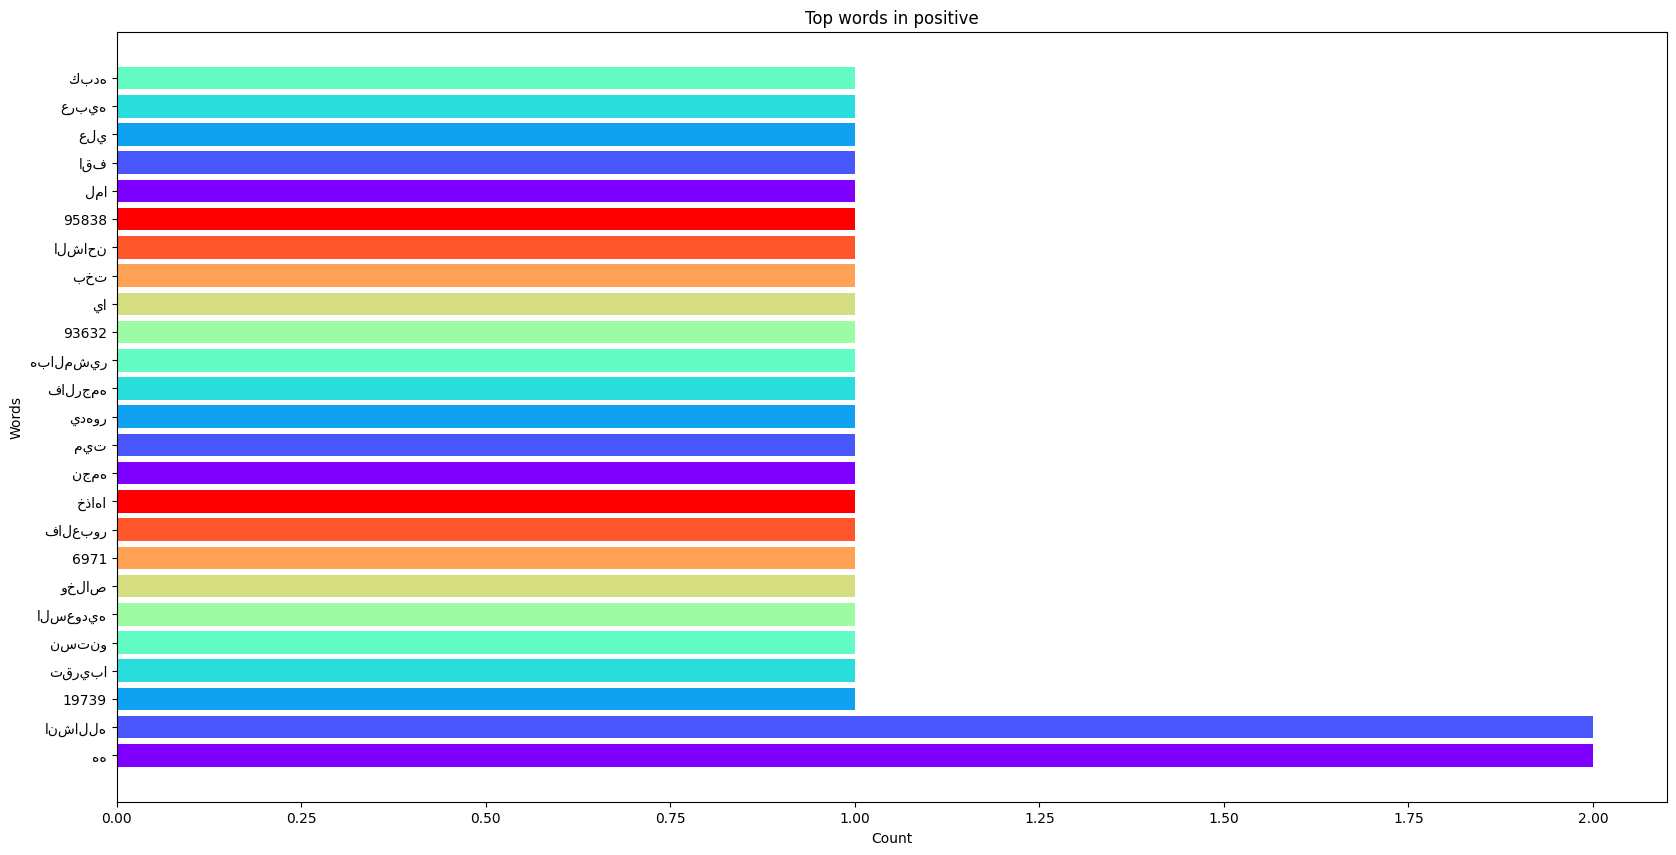

In [53]:
words = []
counts = []
for letter, count in counter.most_common(25):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.rcParams['figure.figsize'] = 20, 10

plt.title('Top words in positive')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

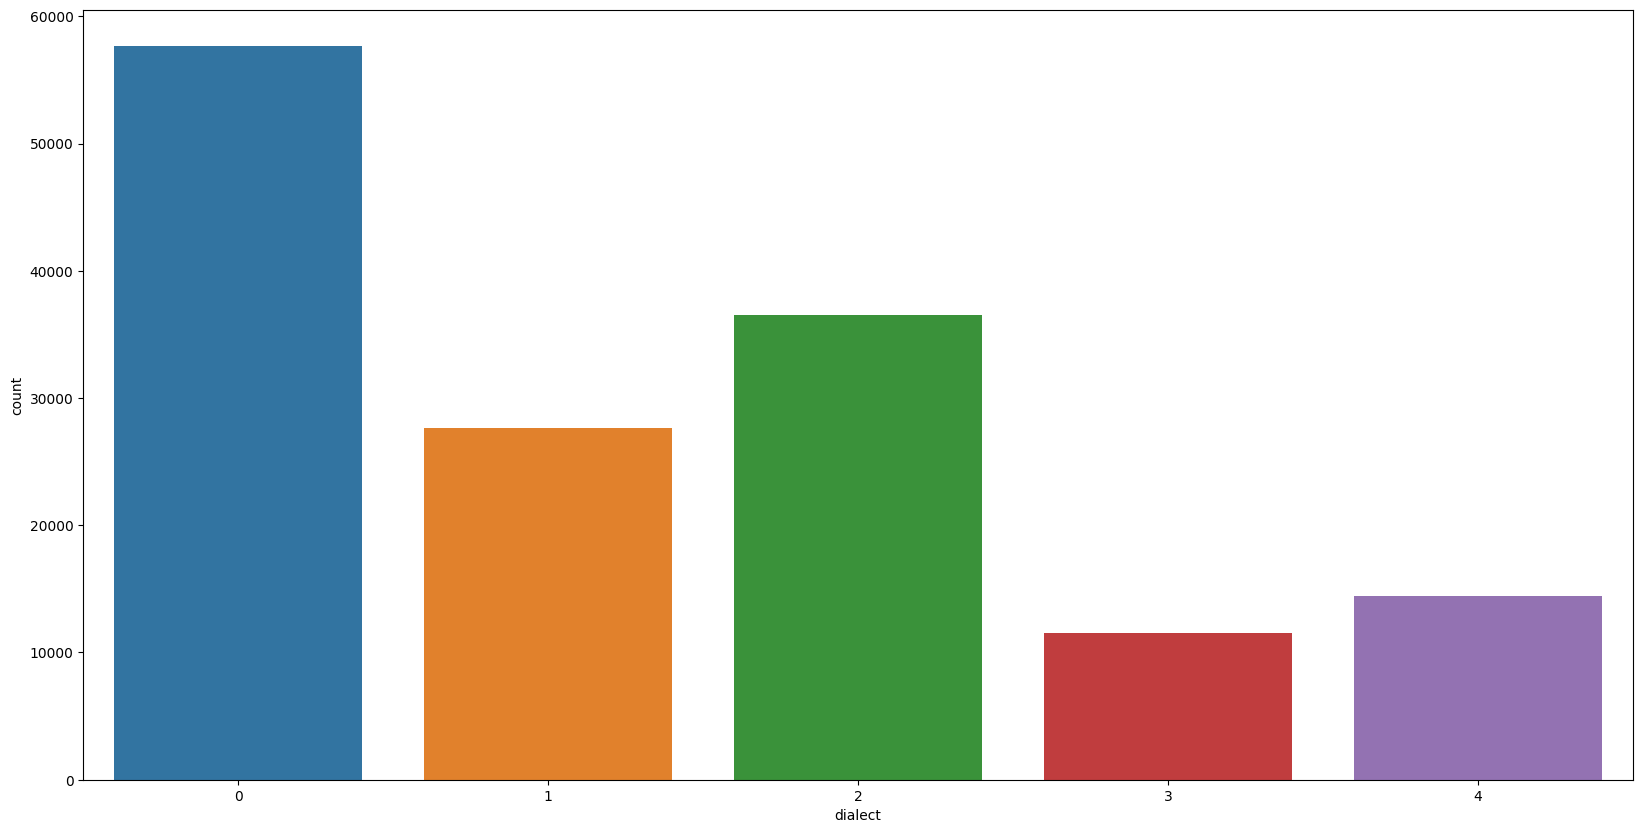

In [54]:
sns.countplot(data= data, x = "dialect")
plt.show()